# Laplace transform in the Brownian setting

> We present here few implementations of the Riccati ODE to obatain representations of the Laplace transform of the signature of a one dimensional Brownian motion. 

Two different lifts are considered: the signature of $X$
$$\mathbb X_t:=(1,X_t,\frac {X_t^2}2,\ldots)$$
and the power sequence
$$\mathbb X_t:=(1,X_t,X_t^2,\ldots).$$

In [ ]:
#| default_exp riccati_bm

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#| export
import numpy as np
import math 
import scipy.special
import cmath
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm.auto import tqdm

## The Riccati operator
Recall that $R$ is the operator mapping the coefficients of $f$ to the coefficients of
$$\mathcal R f=\frac 1 2 (f''(x)+f'(x)^2).$$


### The signature's representaiton
In terms of signture it is given by
$$
R(u)_k = \frac{1}{2} \big(u_{k+2} + \sum_{i+j=k}\binom k i u_{i+1}u_{j+1}\big).
$$
Since implementing an infinitely long sequence is not possibile, we also introduce a truncation's parameter $K$. We then set $R(u)_k=0$ for each $k\geq K$.

In [ ]:
#| export
def R_BM_sig(u,K):
    argument=np.concatenate((u,(0,0)), axis=None)
    Rseq=np.zeros(K+1, dtype=complex)
    for k in range(K+1):
        x=0
        for j in range(0,k+1):
            x=x+scipy.special.comb(k,j)*argument[j+1]*argument[k-j+1]
        y=1/2*(argument[k+2]+x)
        Rseq[k]=y
    return Rseq

### The power sequence representaiton
In terms of power sequence the operator $R$ is given by
$$
R(u)_k = \frac{1}{2} \big((k+1)(k+2)u_{k+2} + \sum_{i+j=k}(i+1)(j+1) u_{i+1}u_{j+1}\big).
$$
Since implementing an infinitely long sequence is not possibile, we also introduce a truncation's parameter $K$. We then set $R(u)_k=0$ for each $k\geq K$.

In [ ]:
#| export
def R_BM_pow(u,K):
    argument=np.concatenate((u,(0,0)), axis=None)
    Rseq=np.zeros(K+1, dtype=complex)
    for k in range(K+1):
        x=0
        for j in range(0,k+1):
            x=x+(j+1)*(k-j+1)*argument[j+1]*argument[k-j+1]
        y=1/2*((k+1)*(k+2)*argument[k+2]+x)
        Rseq[k]=y
    return Rseq

## The corresponding ODEs

We are now investigating the following differential equations
\begin{align*}
\frac{d}{dt} \psi^{sig}(t) &= R^{sig}(\psi^{sig}(t)),& \psi^{sig}(0)&=u^{sig},\\
\frac{d}{dt} \psi^{pow}(t) &= R^{pow}(\psi^{pow}(t)),& \psi^{pow}(0)&=u^{pow}.
\end{align*}
In order to resource to a standard solver (for real valued initial conditions) we need the following auxiliary functions.

In [ ]:
#| export
def model_sig(psi,t,K):
    dpsidt = R_BM_sig(psi,K).real
    return dpsidt

In [ ]:
#| export
def model_pow(psi,t,K):
    dpsidt = R_BM_pow(psi,K).real
    return dpsidt

We are now ready to define the function providing the solution of the Riccati equations given the initial condition and the other needed parameters.

In [ ]:
#| export
def riccati_sol_sig(u_sig,timegrid,K):
    """Sig lift"""
    psi0_sig = np.concatenate((u_sig,np.zeros(K+1-len(u_sig), dtype=complex)))
    return odeint(model_sig,psi0_sig.real,timegrid,args=(K,))

In [ ]:
#| export
def riccati_sol_pow(u_pow,timegrid,K):
    """Pow lift"""
    psi0_pow = np.concatenate((u_pow,np.zeros(K+1-len(u_pow), dtype=complex)))
    return odeint(model_pow,psi0_pow.real,timegrid,args=(K,))

## The affine transform formula

Finally, we can use the affine transform formula to obtain an approximation of 
$$\mathbb E[\exp(\langle \mathbf u,\mathbb X_t\rangle)]=\mathbb E[\exp(\sum_{k=0}^\infty \mathbf u^{sig}_k \frac{X_t^k}{k!})]=\mathbb E[\exp(\sum_{k=0}^\infty \mathbf u^{pow}_k X_t^k)]$$
for each $t\in[0,T]$. It is given by
$$\mathbb E[\exp(\sum_{k=0}^\infty \mathbf u^{sig}_k \frac{X_t^k}{k!})]=\exp(\psi^{sig}(t)_0)\qquad\text{and}\qquad\mathbb E[\exp(\sum_{k=0}^\infty \mathbf u^{pow}_k \frac{X_t^k}{k!})]=\exp(\psi^{pow}(t)_0),$$
respectively.

In [ ]:
#| export
def appr_exp_sig(u_sig,timegrid,K):
    """Sig lift"""
    return np.exp(riccati_sol_sig(u_sig,timegrid,K)[:,0])

In [ ]:
#| export
def appr_exp_pow(u_pow,timegrid,K):
    """Pow lift"""
    return np.exp(riccati_sol_pow(u_pow,timegrid,K)[:,0])

## Numerical experiments

We now implement the theory to approximate
$\mathbb E[\exp(\langle \mathbf u,\mathbb X_t\rangle)]$
for every $t\in[0,T]$.

### Monte Carlo

The next function provides reference values for our target. Observe that coefficients need to be inserted in their signature representation.

In [ ]:
#| export
def MC(u_sig,T,n_MC,N):
    tt=0
    Lap = np.zeros(n_MC, dtype=complex)

    for i in tqdm(range(n_MC)):
        B_run= np.zeros((1,N))
        B_run=np.random.normal(0,np.sqrt(tt), (1,N))
        #print(B)
        exponent_run=u_sig[0]
        for k in range(1,len(u_sig)):
            exponent_run=exponent_run+u_sig[k]/math.factorial(k)*B_run**k 
        Lap[i]=np.mean(np.exp(exponent_run))
        tt+=T/n_MC
    return Lap

We may need to use the following function for change of discretization's grid.

In [ ]:
#| export
def CoD(old_vector,n_old, n_new):
    #ChangeofDiscretisation
    new_vector = np.zeros(n_new)
    for i in range(n_new):
        index=int(min(i*n_old/n_new,n_new-1))
        new_vector[i] = old_vector[index]
    return new_vector 

### A first example

As a first test we compute
$$\mathbb E[\exp(-2\frac{X_t^2}2)]=\mathbb E[\exp(-X_t^2)]$$
for each $t\in[0,1]$.
The corresponding parameters are given in the following cell.

In [ ]:
T=1 # [0,T] time horizon

#u in terms of the sig lift
K_u=5
u_sig=np.zeros(K_u, dtype=complex) 
u_sig[2]=-2

#u in terms of the powers lift
u_pow=u_sig.copy()
for k in range(0,K_u):
    u_pow[k]=u_pow[k]/math.factorial(k)

We then compute the target values using Monte Carlo.

In [ ]:
N=100000 # number of samples
n_MC=1000 # number of times ticks
MonteCarlo = MC(u_sig,T,n_MC,N)

  0%|          | 0/1000 [00:00<?, ?it/s]

We set the time grid and the truncation level.

In [ ]:
n_time=1000 # number of times ticks for the plot
timegrid = np.linspace(0,T,n_time)
K=30

And plot the results.

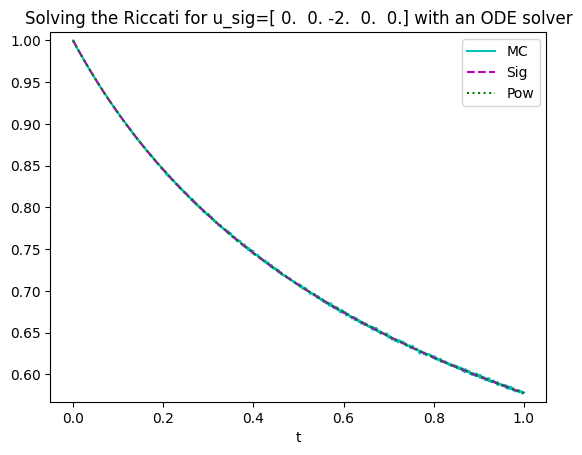

In [ ]:
#Monte Carlo
MonteCarlo_CoD = CoD(np.real(MonteCarlo),n_MC, n_time)
plt.plot(timegrid,MonteCarlo_CoD,'c',label='MC');

#Sig Lift
plt.plot(timegrid,appr_exp_sig(u_sig,timegrid,K),'m--',label='Sig');

#Pow Lift
plt.plot(timegrid,appr_exp_pow(u_pow,timegrid,K),'g:',label='Pow');

plt.ylim(min(MonteCarlo.real-0.01),max(MonteCarlo.real)+0.01)
plt.xlabel("t")
plt.title(f'Solving the Riccati for u_sig={u_sig.real} with an ODE solver')
plt.legend();

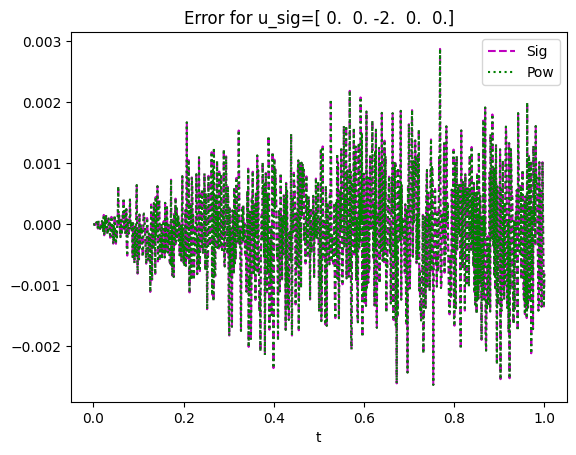

In [ ]:
#Sig Lift
plt.plot(timegrid,appr_exp_sig(u_sig,timegrid,K)-MonteCarlo_CoD,'m--',label='Sig');

#Pow Lift
plt.plot(timegrid,appr_exp_pow(u_pow,timegrid,K)-MonteCarlo_CoD,'g:',label='Pow');

plt.xlabel("t")
plt.title(f'Error for u_sig={u_sig.real}')
plt.legend();

### A second example
As a first test we compute
$$\mathbb E[\exp(-\exp{X_t})]=\mathbb E[\exp(\sum_{k=0}^\infty-\frac{X_t^k}{k!})]=\mathbb E[\exp(\sum_{k=0}^\infty-\frac1{k!}{X_t^k})]$$
for each $t\in[0,1]$.
The corresponding parameters are given in the following cell.

In [ ]:
T=1 # [0,T] time horizon

#u in terms of the sig lift
K_u=20
u_sig=-np.ones(K_u, dtype=complex) 

#u in terms of the powers lift
u_pow=u_sig.copy()
for k in range(0,K_u):
    u_pow[k]=u_pow[k]/math.factorial(k)

We then compute the target values using Monte Carlo. In order to avoid unnecessary errors we introduce an ad-hoc function.

In [ ]:
def MC_exp(u_sig,T,n_MC,N):
    tt=0
    Lap = np.zeros(n_MC, dtype=complex)

    for i in tqdm(range(n_MC)):
        B_run= np.zeros((1,N))
        B_run=np.random.normal(0,np.sqrt(tt), (1,N))
        Lap[i]=np.mean(np.exp(-np.exp(B_run)))
        tt+=T/n_MC
    return Lap

In [ ]:
N=1000000 # number of samples
n_MC=600 # number of times ticks
MonteCarlo = MC_exp(u_sig,T,n_MC,N)

  0%|          | 0/600 [00:00<?, ?it/s]

We set the time grid and the truncation level.

In [ ]:
n_time=1000 # number of times ticks for the plot
timegrid = np.linspace(0,T,n_time)
K=K_u

And plot the results.

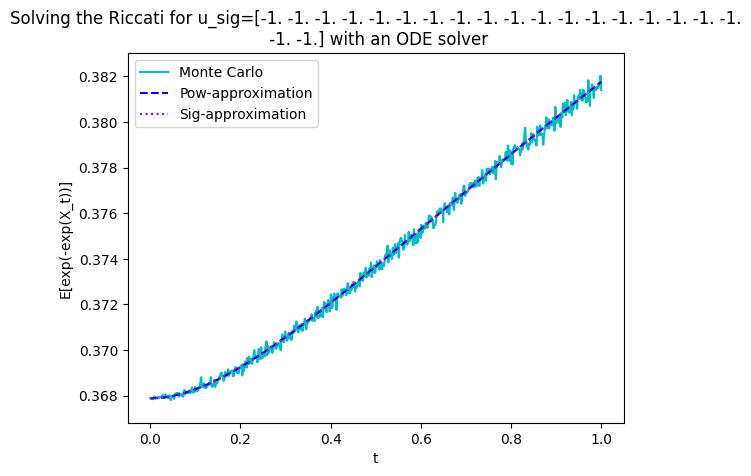

In [ ]:
#Monte Carlo
MonteCarlo_CoD = CoD(np.real(MonteCarlo),n_MC, n_time)
plt.plot(timegrid,MonteCarlo_CoD,'c',label='Monte Carlo');

#Pow Lift
plt.plot(timegrid,appr_exp_pow(u_pow,timegrid,K),'b--',label='Pow-approximation');

#Sig Lift
plt.plot(timegrid,appr_exp_sig(u_sig,timegrid,K),'m:',label='Sig-approximation');

plt.ylim(min(MonteCarlo.real-0.001),max(MonteCarlo.real)+0.001)
plt.xlabel("t")
plt.ylabel("E[exp(-exp(X_t))]")
plt.title(f'Solving the Riccati for u_sig={u_sig.real} with an ODE solver')
plt.legend();

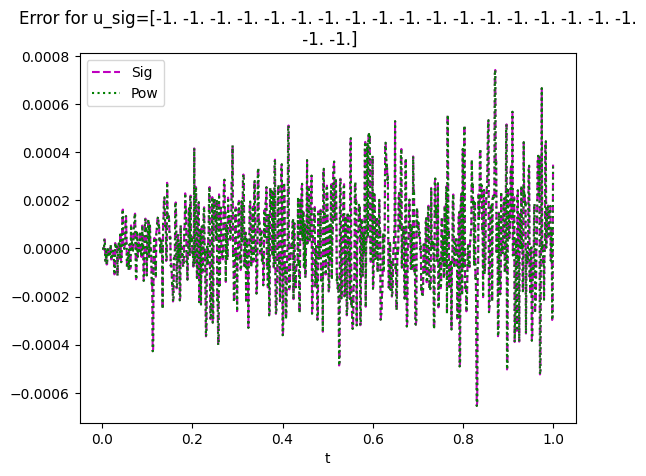

In [ ]:
#Sig Lift
plt.plot(timegrid,appr_exp_sig(u_sig,timegrid,K)-MonteCarlo_CoD,'m--',label='Sig');

#Pow Lift
plt.plot(timegrid,appr_exp_pow(u_pow,timegrid,K)-MonteCarlo_CoD,'g:',label='Pow');

plt.xlabel("t")
plt.title(f'Error for u_sig={u_sig.real}')
plt.legend();

### A third example
As a first test we compute
$$\mathbb E[\exp(-\frac{X_t^4}{4!})]$$
for each $t\in[0,1]$. For this example we stick to the sig lift.
The corresponding parameters are given in the following cell.

In [ ]:
T=1 # [0,T] time horizon

#u in terms of the sig lift
K_u=5
u_sig=np.zeros(K_u, dtype=complex) 
u_sig[4]=-1

We then compute the target values using Monte Carlo.

In [ ]:
N=100000 # number of samples
n_MC=1000 # number of times ticks
MonteCarlo = MC(u_sig,T,n_MC,N)

  0%|          | 0/1000 [00:00<?, ?it/s]

We set the time grid and a range of truncation levels.

In [ ]:
n_time=1000 # number of times ticks for the plot
timegrid = np.linspace(0,T,n_time)
K0=30 #initial value for K
K=K0
DK=10 #increments of K
n_K=5 #number of K

We set several truncation levels and compute the corresponding approximations.

In [ ]:
appr_exp_siglist=[]

for i in tqdm(range(n_K)):
    #Sig lift
    appr_exp_siglist += [appr_exp_sig(u_sig,timegrid,K),]
    K+=DK

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
indices=[]
for k in range(n_K):
    delta=appr_exp_siglist[k][1:]-appr_exp_siglist[k][:-1]
    delta=delta[:len(appr_exp_siglist[k])-1]
    #Cutting after the explosion
    cond1=np.where(delta>0.01)[0]
    cond2=np.where(delta<-0.01)[0]
    index=len(appr_exp_siglist[k])-1
    if len(cond1)>0:
        index=cond1[0]
    if len(cond2)>0:
        index=min(index,cond2[0])
    indices+=[index+2,]

And plot the results for different $K$.

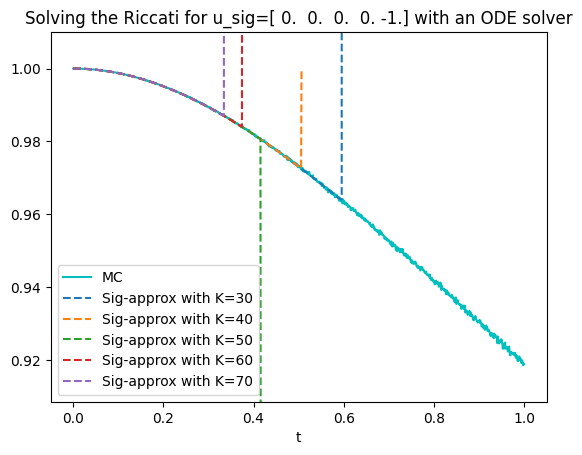

In [ ]:
#Monte Carlo
MonteCarlo_CoD = CoD(np.real(MonteCarlo),n_MC, n_time)
plt.plot(timegrid,MonteCarlo_CoD,'c',label='MC');

for i in range(n_K):
    K=K0+i*DK
    #Sig Lift
    plt.plot(timegrid[:indices[i]],np.minimum(appr_exp_siglist[i][:indices[i]],max(MonteCarlo.real)+10*np.ones(indices[i])),'--',label=f'Sig-approx with K={K}');


plt.ylim(min(MonteCarlo.real-0.01),max(MonteCarlo.real)+0.01)
plt.xlabel("t")
plt.title(f'Solving the Riccati for u_sig={u_sig.real} with an ODE solver')
plt.legend();

As one can see the proposed numerical method is not working for this example. Alternatively, we propose to use the transport equation.

## Riccati-transport equation
We now illustrate how to resource to the transport equation to compute
$$v(t,u):=\mathbb E\Big[\exp\Big(\sum_{k=0}^\infty u_k\frac {X_t^k}{k!}\Big)\Big].$$
This method is appearing to be more stable than then more direct one presented above.

Recall that setting
$$v(0,u)=\exp(u_0)\qquad\text{and}\qquad R(u)_k = \frac{1}{2} \big(u_{k+2} + \sum_{i+j=k}\binom k i u_{i+1}u_{j+1}\big),$$
we obtain that $v$ satisfies the transport equation
$\partial_t v(t,u)=\partial_u^{R(u)}v(t,u),$
where
$$\partial_u^{R(u)}v(t,u)=\lim_{M\to\infty}M\Big(v(t,u+\frac {R(u)}M)-v(t,u)\Big).$$

### Numerical scheme

Discretizing both derivatives we get
$$(T/N)^{-1}\Big(v(t+\frac T N,u)-v(t,u)\Big)
\approx \partial_t v(t,u)
= \partial_u^{R(u)}v(t,u)
\approx M\Big(v(t,u+\frac {R(u)}M)-v(t,u)\Big),$$
which leads to
\begin{align*}
v(t,u)
&\approx v(t-\frac T N,u)+ \frac{MT}N\Big(v(t-\frac T N,u+\frac {R(u)}M)-v(t-\frac T N,u)\Big)\\
&=\lambda(v(t-\frac T N,A_M(u))+ (1-\lambda)v(t-\frac T N,u),
\end{align*}
for $\lambda:=MT/N$ and $A_M(u):=u+{R(u)}/M$.
Starting with $t=Tn/N$ and repeating the procedure $n$ times we thus obtain
\begin{align*}
v(Tn/N,u)
&\approx\sum_{m=0}^n \binom n m(1-\lambda)^{n-m}\lambda^mv(0,A_M^{\circ m}(u))\\
&=\sum_{m=0}^n \binom n m(1-\lambda)^{n-m}\lambda^m \exp(A_M^{\circ m}(u)_0)
.
\end{align*}

Truncation: The only value of $A_M(u)$ that matters for the result is the 0-th. Due to the form of $R$, the only terms of $u$ that enters in $A_M(u)_0$ are $u_0$ and $u_2$. Since we need to apply $A_M(u)$ at most $N$ times, a truncation at level $K\geq 2N$ will not affect the result. We thus fix $K:=2N$.

In [ ]:
#| export
def A_M(M,u_sig,K):
  #Operator A_M
    step=u_sig+R_BM_sig(u_sig,K)/M
    return step

In [ ]:
#| export
def vTu(u,T,N,M):
    K=2*N
    u_running=np.concatenate((u.real,np.zeros(K+1-len(u.real))))
    v0n=np.zeros(N+1)
    space = np.zeros(N)
    lam = T*M/N
    for n in range(N):
        v0last=np.exp(u_running.real[0])
        v0n[n]=v0last
        u_running=A_M(M,u_running,K)
        for m in range(n+1):
            space[n]+=v0n[m]*(1-lam)**(n-m)*lam**(m)*scipy.special.comb(n,m)
    return space

### Back to our third example
As a first test we compute
$$\mathbb E[\exp(-\frac{W_t^4}{4!})]$$
for each $t\in[0,1]$. For this example we stick to the sig lift.
The corresponding parameters are given in the following cell.

In [ ]:
T=1 # [0,T] time horizon

#u in terms of the sig lift
K_u=5
u_sig=np.zeros(K_u, dtype=complex) 
u_sig[4]=-1

We then compute the target values using Monte Carlo.

In [ ]:
N=100000 # number of samples
n_MC=1000 # number of times ticks
MonteCarlo = MC(u_sig,T,n_MC,N)

  0%|          | 0/1000 [00:00<?, ?it/s]

We set the time grid for Monte Carlo.

In [ ]:
time_MC = np.linspace(0,T,n_MC)

We are now ready to plot the result.

  0%|          | 0/4 [00:00<?, ?it/s]

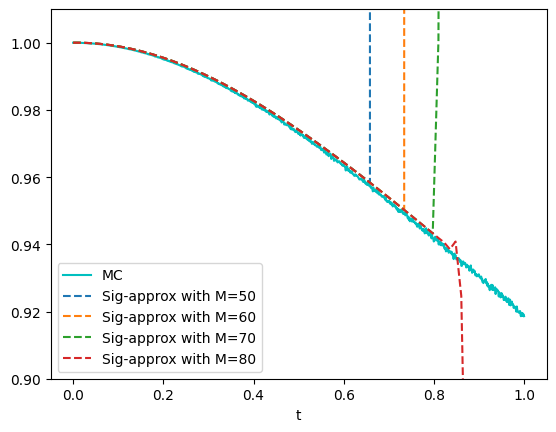

In [ ]:
N=80#number of time's ticks
K=N*2 #truncation
M0=50 
M=M0 #R(u)/M = increment for space derivative

n_k=4 #number of curves to plot
incr_M= 10 #increment of M from curve to curve


plt.plot(time_MC,MonteCarlo,'c',label='MC');


for l in tqdm(range(n_k)):
    time_run = np.linspace(0,T,N)
    space = vTu(u_sig.real,T,N,M)
    
    #Cutting after the explosion
    cond1=np.where(space>1.1)[0]
    cond2=np.where(space<0.91)[0]
    index=len(space)-1
    if len(cond1)>0:
        index=cond1[0]
    if len(cond2)>0:
        index=min(index,cond2[0])
    space_toplot = space[:index+1]
    
    plt.plot(time_run[:len(space_toplot)],space_toplot,'--',label=f'Sig-approx with M={M}');
    M+=10
    
plt.ylim(0.9, 1.01)  
plt.xlabel("t")
#plt.title(f'E[exp(<u_sig,X_t>)] for u={u_sig.real}')  
plt.legend();   

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()